In [1]:
import torch
import torchaudio
import numpy as np
import json
import soundfile as sf
import tqdm
from matplotlib import pyplot as plt
import os

/root/miniconda3/envs/generation/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AudioMapBuilder():
    def __init__(
        self,
        left_channel, 
        right_channel, 
        receiver_positions,
        receiver_rotations, 
        points,
        moving_window: int = 30
    ):
        self.left_channel = left_channel
        self.right_channel = right_channel
        self.receiver_positions = receiver_positions
        self.receiver_rotations = receiver_rotations 
        self.points = points  
        self.moving_window = moving_window 

        self.num_steps = len(self.receiver_positions)
        self.step_size = self.left_channel.size(0) // self.num_steps

    @staticmethod
    def compute_rms(tensor):
        """
        Compute the RMS intensity of a given tensor.
        
        Args:
        tensor (torch.Tensor): The audio samples.
        
        Returns:
        torch.Tensor: The RMS intensity.
        """
        
        return torch.sqrt(torch.mean(tensor ** 2))
    
    def determine_point_side(self, receiver_position, receiver_rotation, point):
        """
        Determine if the point is on the left or right of the receiver based on its orientation.
        
        Parameters:
        receiver_position (tuple): The (x, y) position of the receiver.
        receiver_rotation (float): The rotation angle of the receiver in degrees.
        point (tuple): The (x, y) position of the point to be checked.
        
        Returns:
        str: "l" if the point is on the left, "r" if the point is on the right, "inline" if directly ahead.
        """
        # Convert orientation angle to radians and adjust for Y axis inversion
        receiver_rotation %= 360
        receiver_rotation += 90

        theta = np.radians(receiver_rotation)
        
        # Calculate direction vector from orientation angle (accounting for Y-axis inversion)
        d = np.array([np.cos(theta), -np.sin(theta)])
        
        # Compute vector from receiver to point
        r = np.array(receiver_position)
        o = np.array(point)
        
        v = o - r
        
        # Calculate the determinant (simplified 2D cross product)
        det = d[0] * v[1] - d[1] * v[0]
        
        if det > 0:
            return "r"  # In screen coordinates, a negative determinant indicates the point is to the right
        elif det < 0:
            return "l"  # In screen coordinates, a positive determinant indicates the point is to the left
        else:
            return "inline"
        
    def indicator_function(
            self, 
            louder_side: str,
            receiver_position: np.ndarray, 
            receiver_rotation: np.ndarray,
            point: np.ndarray
        ) -> bool:

        # Determine the orientation of the point relative to the receiver
        point_side = self.determine_point_side(
            receiver_position, 
            receiver_rotation, 
            point
        )

        # Return True if the orientation matches the specified side, False otherwise
        return point_side == louder_side
        
    @staticmethod
    def moving_average(data, window_size):
        """
        Apply a moving average filter to the data.
        
        Args:
        data (np.ndarray): The input data to filter.
        window_size (int): The size of the moving window.
        
        Returns:
        np.ndarray: The filtered data with initial values unfiltered.
        """
        filtered_data = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
        initial_values = data[:window_size - 1]  # Keep the initial values unfiltered
        return np.concatenate((initial_values, filtered_data))
    
    def compute_confidence_coefficients(self):
        """
        Compute the confidence coefficients for given left and right channel audio data.
        """
        
        louder_sides = []
        confidence_coefficients = np.zeros(len(self.points))
        indicator_values = np.zeros((self.num_steps, len(self.points)))
        rms_left_history, rms_right_history = [], []

        for t in range(self.num_steps):
            start_idx = t * self.step_size
            end_idx = (t + 1) * self.step_size

            # Extract the segment for the current time step
            left_segment = self.left_channel[start_idx:end_idx]
            right_segment = self.right_channel[start_idx:end_idx]

            # Compute RMS intensity for both channels
            rms_left = self.compute_rms(left_segment)
            rms_right = self.compute_rms(right_segment)
            rms_left_history.append(rms_left)
            rms_right_history.append(rms_right)

        rms_left_history = self.moving_average(np.array(rms_left_history), self.moving_window)
        rms_right_history = self.moving_average(np.array(rms_right_history), self.moving_window)
        
        for t, (receiver_position, receiver_rotation) in enumerate(zip(self.receiver_positions, self.receiver_rotations)):
            
            louder_side = 'l' if rms_left_history[t] > rms_right_history[t] else 'r'
            louder_sides.append(louder_side)

            # Calculate weight
            WEIGHT = (
                abs(rms_left_history[t] - rms_right_history[t]) 
                / (max(rms_left_history[t], rms_right_history[t]) + 1e-6)
            )
            
            for i, point in enumerate(self.points):
                indicator_values[t, i] = self.indicator_function(louder_side, receiver_position, receiver_rotation, point)
                
                if np.linalg.norm(point - receiver_position) < 10:
                    confidence_coefficients[i] += WEIGHT * indicator_values[t, i]

        return confidence_coefficients, louder_sides, rms_left_history, rms_right_history, indicator_values

In [4]:
# Load the binaural audio file
ROOT_PATH = '../data_gen/3DAVS_benchmark/generation_pipeline/generated_dataset/part_1/5ZKStnWn8Zo/4'

file_path = os.path.join(ROOT_PATH, 'audio_male.wav')

waveform, sample_rate = torchaudio.load(file_path)

with open(os.path.join(ROOT_PATH,'receiver_dof.json'), 'r') as file:
    receiver_path = json.load(file)

# Assume the audio is stereo (2 channels)
left_channel = waveform[0, :]  # First channel (left)
right_channel = waveform[1, :] # Second channel (right)

receiver_positions = [np.array(receiver_path[k]['position'])[[0, 2]] for k in receiver_path.keys()]
receiver_rotations = [np.array(receiver_path[k]['rotation'])[1] for k in receiver_path.keys()]

grid_points = np.load(
    f'../data_gen/3DAVS_benchmark/generation_pipeline/data/scene_datasets/metadata/mp3d/grid_0_5/grid_5ZKStnWn8Zo.npy', 
    allow_pickle=True
).item()['grid_points'].numpy()[:, [0, 2]]

In [5]:
# Compute the confidence coefficients

audio_map_builder = AudioMapBuilder(
    left_channel, 
    right_channel, 
    receiver_positions,
    receiver_rotations,
    grid_points  
)

(confidence_coefficients, 
louder_sides, 
rms_left_history, 
rms_right_history, 
indicator_values) = audio_map_builder.compute_confidence_coefficients()


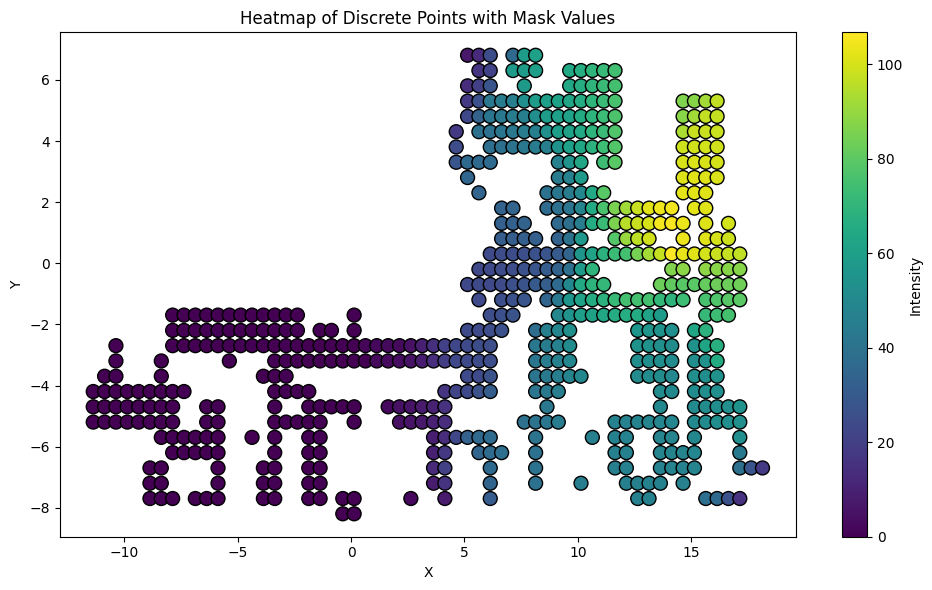

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    np.array(grid_points)[:, 0], 
    -np.array(grid_points)[:, 1], 
    c=np.array(confidence_coefficients), 
    cmap='viridis', 
    s=100, 
    edgecolors='k', 
    linewidths=1
)  # Adjust 's' for point size

plt.colorbar(scatter, label='Intensity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of Discrete Points with Mask Values')
plt.tight_layout()
plt.show()

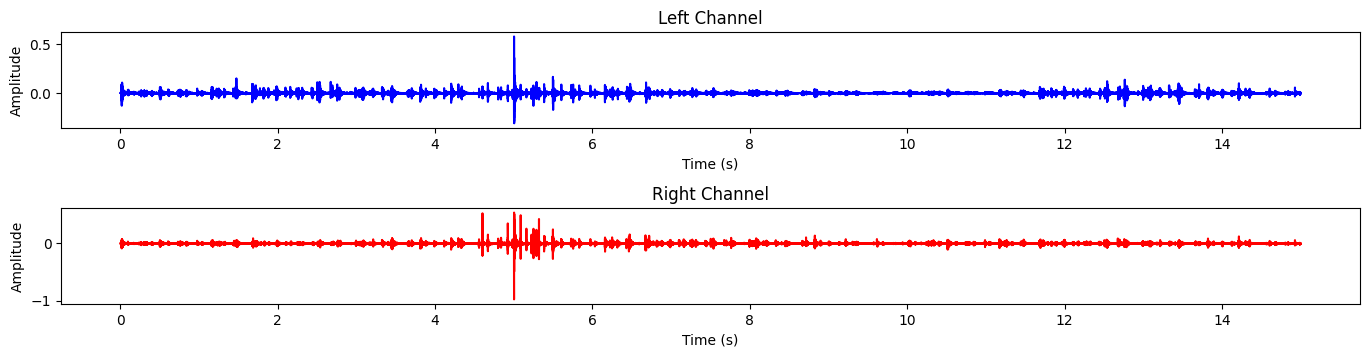

In [68]:
# Load stereo WAV file
y, sr = sf.read(file_path)

# Calculate time axis in seconds
time = np.arange(len(left_channel)) / sr

# Plot each channel as time series
plt.figure(figsize=(14, 5))

plt.subplot(3, 1, 1)
plt.plot(time, y[:, 0], color='b')
plt.title('Left Channel')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(time, y[:, 1], color='r')
plt.title('Right Channel')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

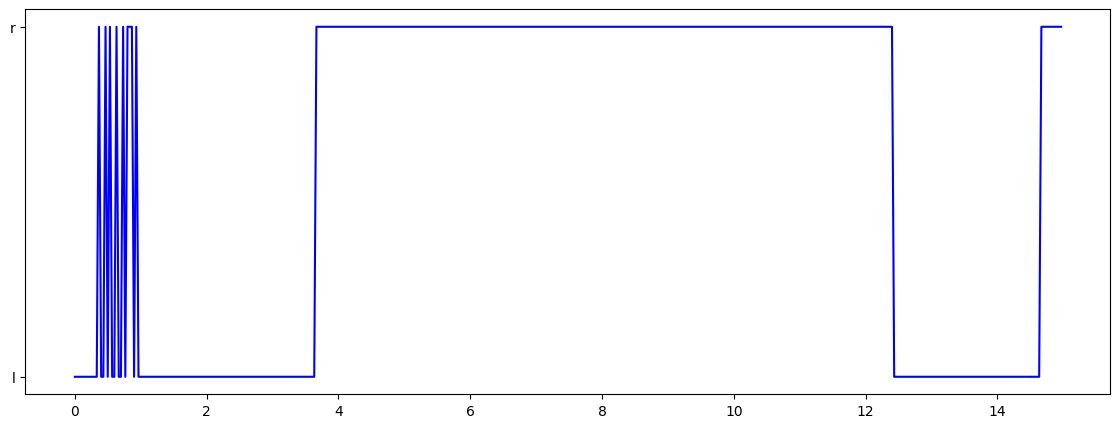

In [69]:
time = np.arange(len(louder_sides)) / 30

plt.figure(figsize=(14, 5))
plt.subplot(1, 1, 1)
plt.plot(time, louder_sides, color='b')

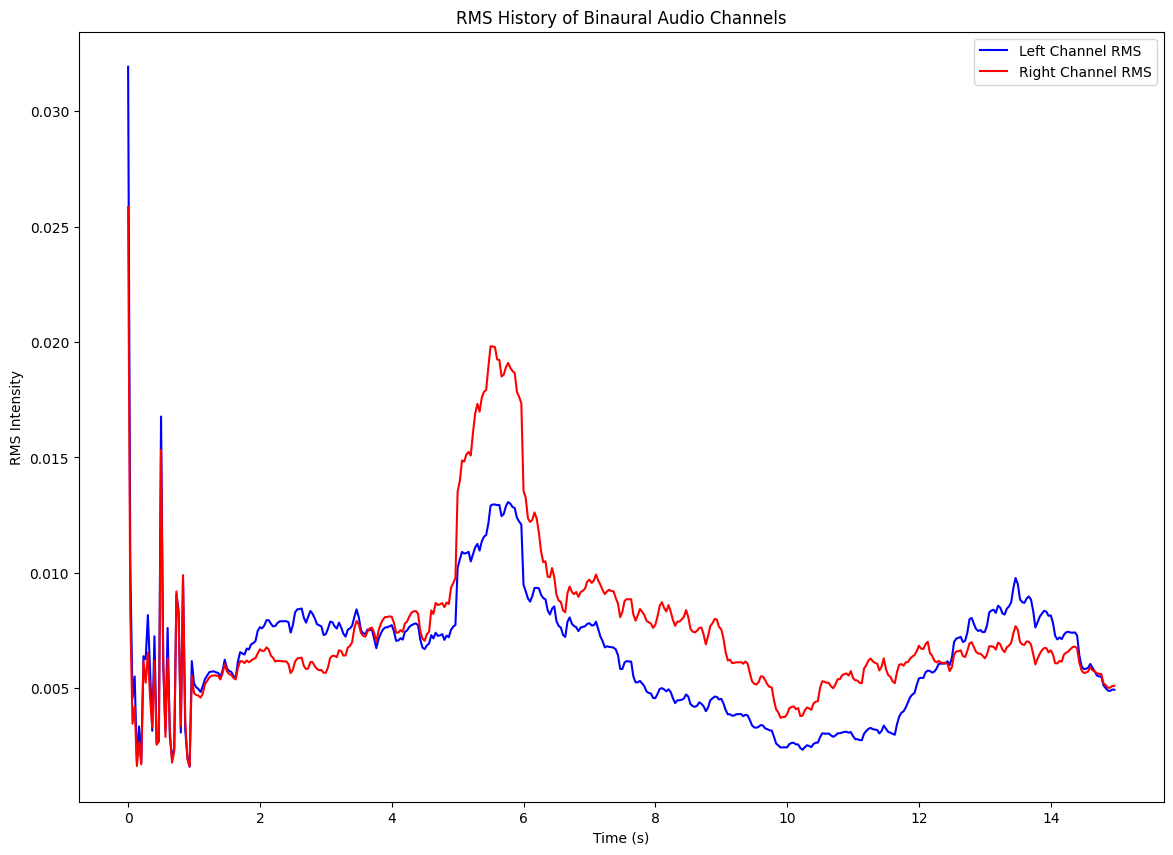

In [70]:
# Plotting the RMS values for both channels
plt.figure(figsize=(14, 10))

plt.plot(time, rms_left_history, color='b', label='Left Channel RMS')
plt.plot(time, rms_right_history, color='r', label='Right Channel RMS')

# Add vertical lines at each time moment
# for t in time:
#     plt.axvline(x=t, color='g', linestyle='--', alpha=0.2)

# Adding titles and labels
plt.title('RMS History of Binaural Audio Channels')
plt.xlabel('Time (s)')
plt.ylabel('RMS Intensity')
plt.legend()

# Display the plot
plt.show()